Annotated References:

https://arxiv.org/pdf/1707.01836.pdf - Successful modeling using a large data set and CNNs with pooling. We can probably replicate this.

https://sci-hub.tw/10.1109/ICACEA.2015.7164783 - Another ECG classification study, but this one is a survey.


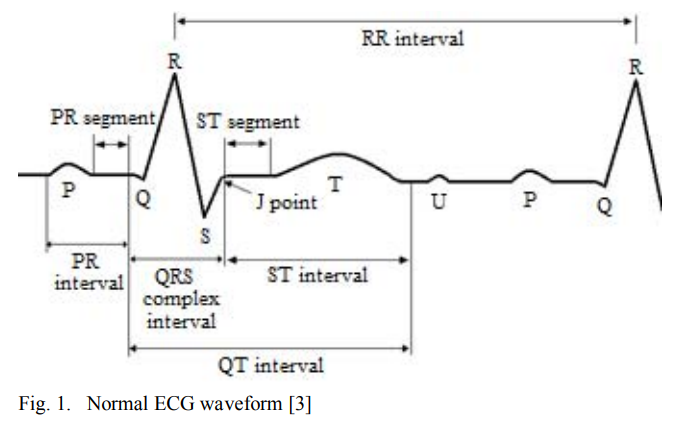

In [1]:
# Neural network setup similar to the reference: https://arxiv.org/pdf/1707.01836.pdf 
#
# Currently a work-in-progress! The intent is to take an input of ECG data from some
# source and train the model to identify arrythmias indicated in the signals. Based
# on the reference, we will look at our data at a rate of 200Hz, and output a 
# prediction for every second of the data.
#
# Some technical TODO issues:
#    1. The shortcut/pooling layers probably aren't right. The convolution
#       layer should not be necessary, so obviously we haven't duplicated
#       the framework from the reference exactly. This might not be all that
#       important!
#    2. This could use a refactor with more descriptive names or some kind
#       of functional approach so that it is less clunky assembling the 
#       network.
#

import keras

# Since the network we are modeling is based on residual networks, the standard
# keras Sequential model will not work since it doesn't natively support the
# shortcut element of residual networks.
from keras import layers, models

# Activations and normalizations
from keras.layers import BatchNormalization, Dropout, ReLU, Activation, Softmax

# Actual NN layers
from keras.layers import Conv1D, MaxPooling1D, Dense, Input

# imports for visualizing the network construction.
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


# Our input, 200 samples across one second
input = Input(shape=(1, 200))

# Initial convolutional layer with the standard normalization and activation
first_conv = Conv1D(64, 16, padding='same')(input)
first_conv = BatchNormalization()(first_conv)
first_conv = ReLU()(first_conv)

# shortcut necessary for the residual network model
shortcut = first_conv

# last non-repeated convolutional layer with standard normalization, activation
# and introduces the first drop-out layer to prevent over-fitting
conv_lay2 = Conv1D(128, 16, padding='same')(first_conv)
conv_lay2 = BatchNormalization()(conv_lay2)
conv_lay2 = ReLU()(conv_lay2)
conv_lay2 = Dropout(0.25)(conv_lay2)
conv_lay2 = Conv1D(256, 16, padding='same')(conv_lay2)

# now we are reshaping our residual input to match the output
shortcut = Conv1D(256, 16, padding='same')(shortcut)
shortcut = MaxPooling1D(pool_size=1)(shortcut)

# from this point until the (nearly) end, the structure is repetitive
pre_rep_layer = layers.add([shortcut, conv_lay2])

# first residual layer (technically second, but this contains the repeated layers)
shortcut = pre_rep_layer

# first stack has some special setup
rep_layer = BatchNormalization()(pre_rep_layer)
rep_layer = ReLU()(rep_layer)
rep_layer = Dropout(0.25)(rep_layer)
rep_layer = Conv1D(512, 16, padding='same')(rep_layer)
rep_layer = BatchNormalization()(rep_layer)
rep_layer = ReLU()(rep_layer)
rep_layer = Dropout(0.25)(rep_layer)
rep_layer = Conv1D(512, 16, padding='same')(rep_layer)

# reshape as above
shortcut = Conv1D(512, 16, padding='same')(shortcut)
shortcut = MaxPooling1D(pool_size=1)(shortcut)

# combine the layers, and now the rest is repitition
rep_layer = layers.add([shortcut, rep_layer])

# second residual layer, probably can be rolled into the loop
shortcut = rep_layer
rep_layer = BatchNormalization()(rep_layer)
rep_layer = ReLU()(rep_layer)
rep_layer = Dropout(0.25)(rep_layer)
rep_layer = Conv1D(512, 16, padding='same')(rep_layer)
rep_layer = BatchNormalization()(rep_layer)
rep_layer = ReLU()(rep_layer)
rep_layer = Dropout(0.25)(rep_layer)
rep_layer = Conv1D(512, 16, padding='same')(rep_layer)
shortcut = Conv1D(512, 16, padding='same')(shortcut)
shortcut = MaxPooling1D(pool_size=1)(shortcut)
rep_layer = layers.add([shortcut, rep_layer])

# repeated residual layers
factor = 1
for x in range(1,14):
    shortcut = rep_layer

    rep_layer = BatchNormalization()(rep_layer)
    rep_layer = ReLU()(rep_layer)
    rep_layer = Dropout(0.25)(rep_layer)
    rep_layer = Conv1D(512*(2**factor), 16, padding='same')(rep_layer)
    rep_layer = BatchNormalization()(rep_layer)
    rep_layer = ReLU()(rep_layer)
    rep_layer = Dropout(0.25)(rep_layer)
    rep_layer = Conv1D(512*(2**factor), 16, padding='same')(rep_layer)

    shortcut = Conv1D(512*(2**factor), 16, padding='same')(shortcut)
    shortcut = MaxPooling1D(pool_size=1)(shortcut)

    rep_layer = layers.add([shortcut, rep_layer])
    # original authors scaled the filter count at this rate
    if x % 4 == 0:
        factor += 1

# final layers/activations/normalizations!
rep_layer = BatchNormalization()(rep_layer)
rep_layer = ReLU()(rep_layer)
rep_layer = Dense(14)(rep_layer)
rep_layer = Softmax()(rep_layer)

# specify the model
model = models.Model(inputs=[input], outputs=[rep_layer])

# set up the optimization
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Un-comment the line below to produce a graphic representation of the network
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


Using TensorFlow backend.
